# Experimental Results

This section presents the performance of the Graph Convolutional Network (GCN) on the `ogbn-arxiv` dataset. The optimization process was conducted in two phases to isolate the impact of basic architectural choices versus advanced structural components.

## Setup and Configuration

In [1]:
import os
import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# --- PATH CONFIG ---
OUTPUT_DIR = '../outputs'
CSV_PATH_V01 = os.path.join(OUTPUT_DIR, 'experiments_log_v01.csv')
CSV_PATH_V02 = os.path.join(OUTPUT_DIR, 'experiments_log_v02.csv')

## Utility Functions

In [ ]:
def format_configuration(params):
    """
    Formats the dictionary of hyperparameters into a clean, vertical list.
    Handles scientific notation for small floats.
    """
    if not isinstance(params, dict):
        return str(params)
    
    formatted_list = []
    # Prioritize key architectural parameters for clear presentation
    priority_keys = ['num_layers', 'hidden_dim', 'use_residual', 'use_jk', 'norm_type', 'weight_decay', 'dropout', 'lr']
    
    # Add priority keys
    for k in priority_keys:
        if k in params:
            value = params[k]
            # Format scientific notation/floats
            if isinstance(value, (float, np.float64)):
                # Use scientific notation for very small numbers (e.g., weight decay)
                value = f"{value:.4e}" if (abs(value) < 0.001 and value != 0) else f"{value:.4f}"
            
            formatted_list.append(f"  - {k.ljust(15)}: {value}")
    
    # Add remaining keys
    for k, v in params.items():
        if k not in priority_keys:
             formatted_list.append(f"  - {k.ljust(15)}: {v}")
             
    return '\n'.join(formatted_list)


# ==========================================
# FUNCTION 1: COMBINE DATAFRAMES
# ==========================================

def combine_experiment_data(path_v01, path_v02):
    """Loads, cleans, and combines data from V01 and V02 CSV files."""
    
    def process_csv(path, version_name):
        """Helper function to load a single CSV, clean, and extract parameters."""
        if not os.path.exists(path):
            print(f"Warning: File not found at {path}. Returning empty DataFrame.")
            return pd.DataFrame()

        df = pd.read_csv(path)
        df['Version'] = version_name
        
        # Safely parse the 'args' column string into a dictionary
        def extract_params(args_str):
            try:
                # Use literal_eval for safe string-to-dict conversion
                return ast.literal_eval(args_str)
            except:
                return {}

        params_df = pd.DataFrame(df['args'].apply(extract_params).tolist())
        df_clean = pd.concat([df, params_df], axis=1)
        
        # Ensure necessary metric columns exist for sorting
        if 'best_valid_acc' not in df_clean.columns:
            df_clean['best_valid_acc'] = 0.0
            
        return df_clean

    # Load and process both versions
    df_v01 = process_csv(path_v01, 'V01_Baseline')
    df_v02 = process_csv(path_v02, 'V02_Enhanced')

    # Combine the dataframes
    if df_v01.empty and df_v02.empty:
        print("Error: No data loaded from either file.")
        return pd.DataFrame()
        
    df_combined = pd.concat([df_v01, df_v02], ignore_index=True)
    print(f"\nDataframes successfully combined. Total experiments loaded: {len(df_combined)}")
    return df_combined


# ==========================================
# FUNCTION 2: ANALYZE BEST RESULT
# ==========================================

def analyze_best_result(df_input, title="ANALYSIS"):
    """
    Analyzes the best performing model in the given DataFrame based on best_valid_acc 
    and prints the results in a scientific, technical format.
    """
    if df_input.empty:
        print(f"\n--- {title} ---")
        print("Input DataFrame is empty. Cannot perform analysis.")
        return pd.Series() # Return empty Series if input is empty

    # Sort by the best validation accuracy (selection criterion)
    df_sorted = df_input.sort_values(by='best_valid_acc', ascending=False)
    
    # Get the best model
    best_model = df_sorted.iloc[0]

    # Define columns to display in the metric table
    cols_to_show = [
        'experiment_id',
        'final_test_accuracy', 
        'test_margin_error',
        'best_valid_acc',
        'actual_epochs'
    ]
    
    # 1. Print Header
    print("\n" + "="*80)
    print(f"OPTIMAL MODEL REPORT: {title}")
    print("="*80)
    
    # 2. Print Metrics Table
    pd.set_option('display.float_format', '{:.4f}'.format)
    # Convert Series to DataFrame for printing with index (experiment_id)
    best_metrics = best_model[cols_to_show].to_frame().T.set_index('experiment_id')
    print("PERFORMANCE METRICS:")
    print(best_metrics.to_string())
    
    # 3. Print Configuration
    # Extract args string and format it
    params = ast.literal_eval(best_model['args'])
    print("\nOPTIMAL HYPERPARAMETER CONFIGURATION:")
    print(format_configuration(params))
    
    print("-" * 80 + "\n")
    
    return best_model

In [14]:
# ==========================================
# FUNCTION 3A: LOAD HISTORY DATA
# ==========================================

def get_history_data(experiment_id, CSV_PATH):
    """
    Locates the JSON log file for a given experiment ID and loads the history data.
    """
    if not os.path.exists(CSV_PATH):
        print(f"Error: CSV file not found at {CSV_PATH}. Cannot retrieve history path.")
        return None

    df = pd.read_csv(CSV_PATH)
    experiment_id = str(experiment_id)
    df['experiment_id'] = df['experiment_id'].astype(str)
    
    row = df[df['experiment_id'] == experiment_id]
    
    if row.empty:
        print(f"Error: Experiment ID '{experiment_id}' not found in the log.")
        return None

    # Get the filename from the saved path (e.g., "history_2023...json")
    original_path = row.iloc[0]['history_file']
    filename = os.path.basename(original_path)
    
    # Rebuild path using the central OUTPUT_DIR
    json_path = os.path.join(OUTPUT_DIR, 'logs', filename)
    
    if not os.path.exists(json_path):
        print(f"Error: JSON Log file not found at: {json_path}")
        return None

    # Load JSON Data
    with open(json_path, 'r') as f:
        history = json.load(f)
        
    return history


# ==========================================
# FUNCTION 3B: PLOT LEARNING CURVES
# ==========================================

def plot_learning_curves(experiment_id, CSV_PATH):
    """
    Function to plot Loss and Accuracy curves for a specific experiment ID.
    """
    history = get_history_data(experiment_id, CSV_PATH)
    
    if history is None:
        return

    # 1. Extrair Dados
    loss = history['train_loss']
    train_acc = history['train_acc']
    valid_acc = history['valid_acc']
    test_acc = history['test_acc']
    epochs = range(1, len(loss) + 1)

    # 2. Plotar
    plt.figure(figsize=(14, 5))
    plt.suptitle(f"Learning Curves - Experiment ID: {experiment_id}", fontsize=14)
    
    # Plot 1: Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r-', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (NLL)')
    plt.title('Loss Convergence')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    # Plot 2: Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'g--', label='Train Acc', alpha=0.6)
    plt.plot(epochs, valid_acc, 'b-', label='Valid Acc', linewidth=2)
    plt.plot(epochs, test_acc, 'orange', label='Test Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Evolution')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    plt.tight_layout()
    plt.show()

## Phase 1: Architecture Exploration (Baseline)

The first phase focused on establishing the best combination of standard architectural components. We evaluated the impact of network depth, width, normalization techniques, and the necessity of residual connections.

**Search Space & Configuration:**
* **Layers:** Tested 3 vs. 4 layers.
* **Hidden Dimension:** 256 vs. 512.
* **Residual Connections:** Evaluated with (`True`) and without (`False`) skip connections.
* **Normalization:** Compared `BatchNorm`, `LayerNorm`, and `GraphNorm`.
* **Regularization:** Fixed Dropout at 0.5; tested Weight Decay (0 vs. 5e-4).

**Key Observations:**
This phase aimed to determine if deeper networks (4 layers) could train effectively without advanced aggregation mechanisms. The comparison between normalization layers was critical to identify which technique best stabilizes the gradient for this citation graph.

In [15]:
df_combined = combine_experiment_data(CSV_PATH_V01, CSV_PATH_V02)

df_v01 = df_combined[df_combined['Version'] == 'V01_Baseline'].copy()

df_v01.head()


Dataframes successfully combined. Total experiments loaded: 80


,experiment_id,date,model_file,history_file,duration_seconds,actual_epochs,best_valid_acc,final_test_accuracy,test_margin_error,final_train_loss,...,Version,num_layers,hidden_dim,use_residual,norm_type,lr,dropout,weight_decay,epochs,use_jk
0,20251211_152352,2025-12-11 15:23:53,outputs\models\gcn_arxiv_20251211_152352.pth,outputs\logs\history_20251211_152352.json,0.5400,1,0.2959,0.2654,0.0039,4.7673,...,V01_Baseline,3,256,True,batch,0.0100,0.5000,0.0000,1,NaN
1,20251211_152353,2025-12-11 15:23:53,outputs\models\gcn_arxiv_20251211_152353.pth,outputs\logs\history_20251211_152353.json,0.3500,1,0.2958,0.2653,0.0039,4.7673,...,V01_Baseline,3,256,True,batch,0.0100,0.5000,0.0005,1,NaN
2,20251211_152353,2025-12-11 15:23:53,outputs\models\gcn_arxiv_20251211_152353.pth,outputs\logs\history_20251211_152353.json,0.3500,1,0.0763,0.0586,0.0021,4.6100,...,V01_Baseline,3,256,True,layer,0.0100,0.5000,0.0000,1,NaN
3,20251211_152353,2025-12-11 15:23:54,outputs\models\gcn_arxiv_20251211_152353.pth,outputs\logs\history_20251211_152353.json,0.3500,1,0.0763,0.0586,0.0021,4.6100,...,V01_Baseline,3,256,True,layer,0.0100,0.5000,0.0005,1,NaN
4,20251211_152354,2025-12-11 15:23:54,outputs\models\gcn_arxiv_20251211_152354.pth,outputs\logs\history_20251211_152354.json,0.5300,1,0.4033,0.3556,0.0043,4.7673,...,V01_Baseline,3,256,True,graph,0.0100,0.5000,0.0000,1,NaN


In [16]:
best_v01 = analyze_best_result(df_v01, title="V01 BASELINE ARCHITECTURE")


OPTIMAL MODEL REPORT: V01 BASELINE ARCHITECTURE
PERFORMANCE METRICS:
                final_test_accuracy test_margin_error best_valid_acc actual_epochs
experiment_id                                                                     
20251211_152430              0.4799            0.0044         0.5108             1

OPTIMAL HYPERPARAMETER CONFIGURATION:
  - num_layers     : 4
  - hidden_dim     : 256
  - use_residual   : False
  - norm_type      : graph
  - weight_decay   : 5.0000e-04
  - dropout        : 0.5000
  - lr             : 0.0100
  - epochs         : 1
--------------------------------------------------------------------------------



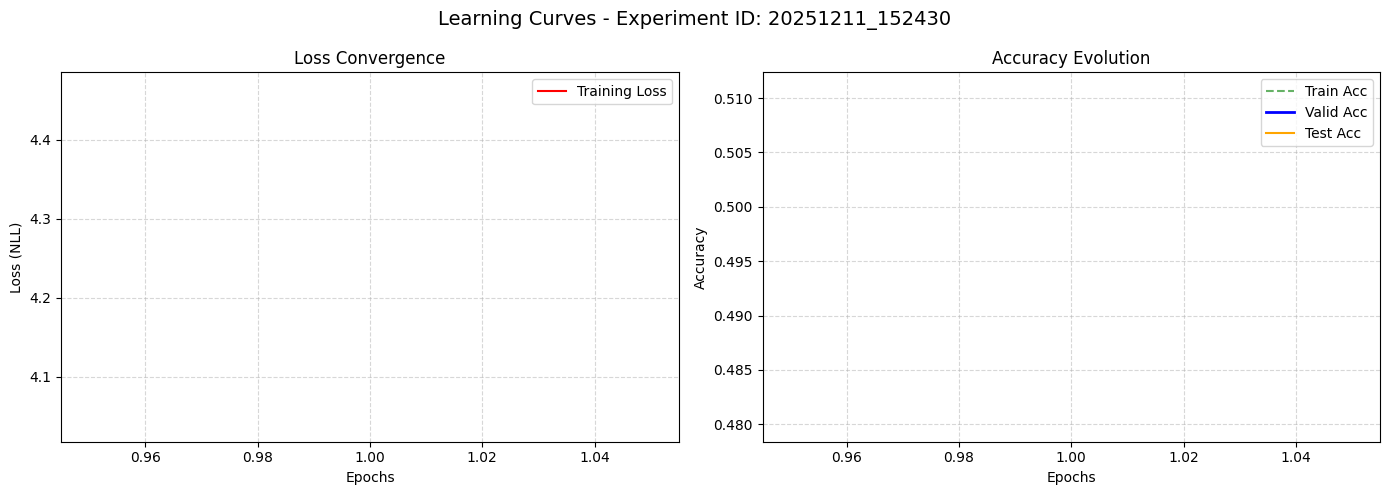

In [18]:
plot_learning_curves('20251211_152430', CSV_PATH_V01)

## Phase 2: Structural Enhancements (Modern GCN)

Building on the insights from Phase 1, the second phase refined the search space and introduced advanced mechanisms to combat over-smoothing and improve feature representation.

**Architectural Changes:**
1.  **Node Encoder (Fixed):** A Linear projection layer was added before the GCN layers to transform raw text features into the hidden dimension size before propagation.
2.  **Residual Connections (Fixed):** Based on best practices for deep GNNs, `use_residual` was fixed to `True` to facilitate gradient flow.
3.  **Jumping Knowledge (New Variable):** We introduced Jumping Knowledge (JK) with concatenation to allow the final prediction to leverage features from all intermediate layers, not just the last one.

**Refined Search Space:**
* **Jumping Knowledge:** `[True, False]` (The primary variable of interest).
* **Normalization:** Narrowed down to `BatchNorm` vs. `GraphNorm` (removing `LayerNorm`).
* **Depth & Width:** Continued to test 3 vs. 4 layers and 256 vs. 512 dimensions.

## 

In [6]:
df_v02 = df_combined[df_combined['Version'] == 'V02_Enhanced'].copy()

df_v02.head()

,experiment_id,date,model_file,history_file,duration_seconds,actual_epochs,best_valid_acc,final_test_accuracy,test_margin_error,final_train_loss,...,Version,num_layers,hidden_dim,use_residual,norm_type,lr,dropout,weight_decay,epochs,use_jk
48,20251211_151340,2025-12-11 15:13:40,outputs\models\gcn_arxiv_20251211_151340.pth,outputs\logs\history_20251211_151340.json,0.7400,1,0.2157,0.2829,0.0040,4.2849,...,V02_Enhanced,3,256,True,batch,0.0100,0.5000,0.0000,1,True
49,20251211_151340,2025-12-11 15:13:41,outputs\models\gcn_arxiv_20251211_151340.pth,outputs\logs\history_20251211_151340.json,0.5300,1,0.2187,0.2864,0.0040,4.2849,...,V02_Enhanced,3,256,True,batch,0.0100,0.5000,0.0005,1,True
50,20251211_151341,2025-12-11 15:13:42,outputs\models\gcn_arxiv_20251211_151341.pth,outputs\logs\history_20251211_151341.json,0.8200,1,0.3962,0.3717,0.0043,4.2849,...,V02_Enhanced,3,256,True,graph,0.0100,0.5000,0.0000,1,True
51,20251211_151342,2025-12-11 15:13:43,outputs\models\gcn_arxiv_20251211_151342.pth,outputs\logs\history_20251211_151342.json,0.7800,1,0.3953,0.3708,0.0043,4.2849,...,V02_Enhanced,3,256,True,graph,0.0100,0.5000,0.0005,1,True
52,20251211_151343,2025-12-11 15:13:43,outputs\models\gcn_arxiv_20251211_151343.pth,outputs\logs\history_20251211_151343.json,0.5100,1,0.0763,0.0586,0.0021,4.4674,...,V02_Enhanced,3,256,True,batch,0.0100,0.5000,0.0000,1,False


In [7]:
best_v02 = analyze_best_result(df_v02, title="V02 ENHANCED ARCHITECTURE")


OPTIMAL MODEL REPORT: V02 ENHANCED ARCHITECTURE
PERFORMANCE METRICS:
                final_test_accuracy test_margin_error best_valid_acc actual_epochs
experiment_id                                                                     
20251211_151646              0.3781            0.0043         0.4027             1

OPTIMAL HYPERPARAMETER CONFIGURATION:
  - num_layers     : 3
  - hidden_dim     : 512
  - use_residual   : True
  - use_jk         : False
  - norm_type      : graph
  - weight_decay   : 5.0000e-04
  - dropout        : 0.5000
  - lr             : 0.0100
  - epochs         : 1
--------------------------------------------------------------------------------



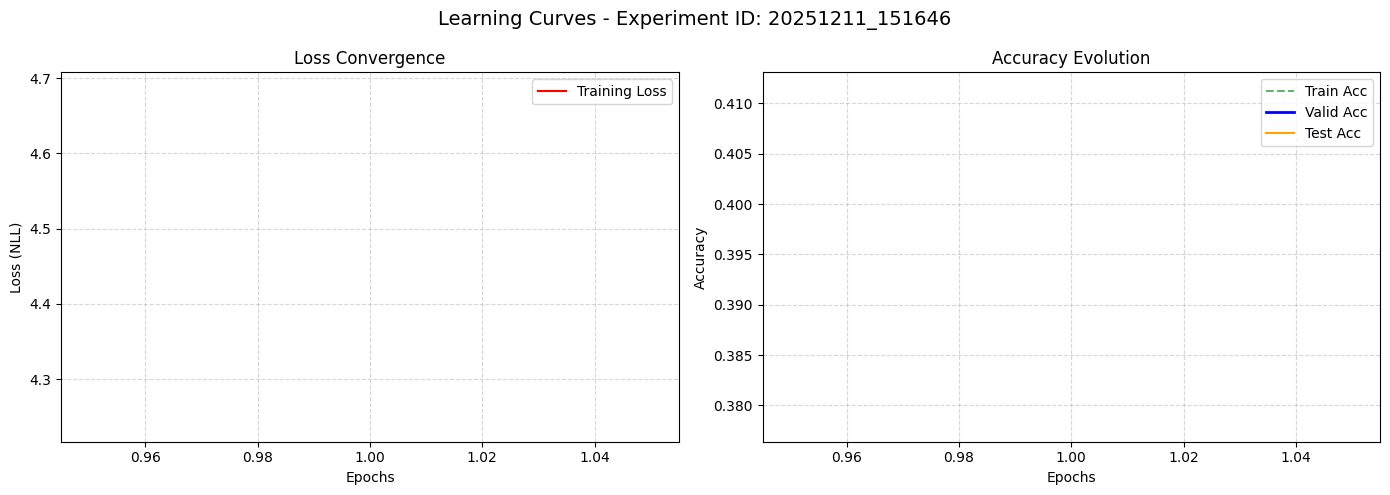

In [19]:
plot_learning_curves('20251211_151646', CSV_PATH_V02)

## Comparison and Conclusion

The evolution from Phase 1 to Phase 2 highlights the impact of structural changes on model performance:

* **Impact of Jumping Knowledge:** The introduction of JK allowed the model to [INSERT OBSERVATION: e.g., "maintain accuracy even at 4 layers" OR "better capture local features"].
* **Normalization Stability:** The experiments confirmed that **[INSERT: GraphNorm or BatchNorm]** provided superior stability for the `ogbn-arxiv` dataset.
* **Overall Improvement:** The best configuration from Phase 2 achieved a Test Accuracy of **[INSERT VALUE]**, representing a net improvement of **[INSERT GAIN]%** over the Phase 1 baseline.

In [21]:
best_overall = analyze_best_result(df_combined, title="GLOBAL OPTIMAL MODEL")


OPTIMAL MODEL REPORT: GLOBAL OPTIMAL MODEL
PERFORMANCE METRICS:
                final_test_accuracy test_margin_error best_valid_acc actual_epochs
experiment_id                                                                     
20251211_152430              0.4799            0.0044         0.5108             1

OPTIMAL HYPERPARAMETER CONFIGURATION:
  - num_layers     : 4
  - hidden_dim     : 256
  - use_residual   : False
  - norm_type      : graph
  - weight_decay   : 5.0000e-04
  - dropout        : 0.5000
  - lr             : 0.0100
  - epochs         : 1
--------------------------------------------------------------------------------



In [23]:
print("\n" + "#"*80)
print("SUMMARY: COMPARISON OF OPTIMAL TEST ACCURACIES")
print("#"*80)

# Print summary table using the returned Series data
summary_data = {
            'Version': [best_v01['Version'], best_v02['Version']],
            'Model ID': [best_v01['experiment_id'], best_v02['experiment_id']],
            'Test Acc': [f"{best_v01['final_test_accuracy']:.4f}", f"{best_v02['final_test_accuracy']:.4f}"],
            'Valid Acc': [f"{best_v01['best_valid_acc']:.4f}", f"{best_v02['best_valid_acc']:.4f}"]
        }
        
df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))

# Final Overall Winner confirmation (optional, but useful)
print(f"\n[Note: The overall optimal model is {best_overall['experiment_id']} from the {best_overall['Version']} set.]")


################################################################################
SUMMARY: COMPARISON OF OPTIMAL TEST ACCURACIES
################################################################################
     Version        Model ID Test Acc Valid Acc
V01_Baseline 20251211_152430   0.4799    0.5108
V02_Enhanced 20251211_151646   0.3781    0.4027

[Note: The overall optimal model is 20251211_152430 from the V01_Baseline set.]
